## NewProfile.csv <a id='top'></a>

### Contents
1. <a href=#eda>EDA</a>
    1. <a href=#var>Analysis of Variables</a>
1. <a href=#surp>Recommendation using Surprise package</a>

In [3]:
# import libraries

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# Data visualisation
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt

In [4]:
profiles = pd.read_csv("NewProfile.csv")
profiles.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Age Group,Gender
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,50-59,male
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,>60,male
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,40-49,female
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,40-49,male
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,>60,female


<a id='eda'></a>
### Preprocessing: Removing Helpfulness Columns and Formatting Time

The 'Time' column is in epoch time/ UNIX timeframe. We shall convert it to datetime type. 

<a href=#top>(back to top)</a>

In [5]:
def con_epoch(row):
    """
    function to convert epoch time to string in '%Y-%m-%d %H:%M:%S' format
    """
    dt_format = datetime.fromtimestamp(row.Time)
    return dt_format.strftime('%Y-%m-%d %H:%M:%S')

profiles.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1, inplace=True)
profiles['Time'] = profiles.apply(con_epoch, axis=1)
profiles.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,2011-04-27 08:00:00,Good Quality Dog Food,I have bought several of the Vitality canned d...,50-59,male
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,2012-09-07 08:00:00,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,>60,male
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,2008-08-18 08:00:00,"""Delight"" says it all",This is a confection that has been around a fe...,40-49,female
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,2011-06-13 08:00:00,Cough Medicine,If you are looking for the secret ingredient i...,40-49,male
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,2012-10-21 08:00:00,Great taffy,Great taffy at a great price. There was a wid...,>60,female


In [6]:
# time suspected to all be 08:00:00

p = profiles.copy()
p['Time'] = p.apply(lambda row: row.Time[-8:], axis=1)
p['Time'].unique()

array(['08:00:00'], dtype=object)

In [7]:
# We shall remove the time component from the Time column 
# and convert all Time entries to datetime

profiles['Time'] = profiles.apply(lambda row: datetime.strptime(row.Time[:-9], '%Y-%m-%d'), axis=1)
profiles.sort_values(by='Time', ascending=False, inplace=True) # sort rows according to most recently
profiles.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
14783,14784,B000S859NC,A2H7STZ2URUCOE,"Christopher Whedon ""the odd bead""",5,2012-10-26,GREAT TEA,Rooibos Natural Red tea is something of a pers...,20-29,male
440485,440486,B002ZOCEMG,A1LIP0F4R542OQ,A,1,2012-10-26,:(,I just got this coffee a few days ago. I had c...,40-49,male
535436,535437,B001EO5RSQ,A33W5JAFGHYRQZ,"ghermine ""ghermine""",5,2012-10-26,Love this Cereal!,There is nothing else like this on the market....,20-29,male
7820,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",1,2012-10-26,Don't like the taste,I do not like sour taste and this has a sour k...,20-29,female
146094,146095,B000SDKDM4,A18NG9I9MT2V8I,"Emm ""Emm""",5,2012-10-26,Deeeee-lish!,For far too long I was a devotee of the Starbu...,<20,male


In [8]:
profiles.shape

(568454, 10)

### Preprocessing: Filtering duplicate entries 

Duplicates defined as having same row entries, excluding 'Id' and 'ProductId' 

In [9]:
# filter out duplicates, keep the first (latest) occurrence of the duplicated row 

profiles = profiles.drop_duplicates(subset=profiles.columns[2:].to_list(), keep='first')
profiles.shape

# 69.5% data remaining

(395200, 10)

In [10]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395200 entries, 14783 to 150523
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Id           395200 non-null  int64         
 1   ProductId    395200 non-null  object        
 2   UserId       395200 non-null  object        
 3   ProfileName  395189 non-null  object        
 4   Score        395200 non-null  int64         
 5   Time         395200 non-null  datetime64[ns]
 6   Summary      395197 non-null  object        
 7   Text         395200 non-null  object        
 8   Age Group    395200 non-null  object        
 9   Gender       395200 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 33.2+ MB


In [11]:
profiles.isna().any() # ProfileName and Summary contain Null values

Id             False
ProductId      False
UserId         False
ProfileName     True
Score          False
Time           False
Summary         True
Text           False
Age Group      False
Gender         False
dtype: bool

In [12]:
ncount = len(profiles)
ncount

395200

<a id='var'></a>
### Analysis of Target Variable: Ratings
<a href=#top>(back to top)</a>

### Time Series 

In [13]:
profiles['Time'].describe(datetime_is_numeric=True)

count                           395200
mean     2011-01-31 01:57:17.052740096
min                1999-10-08 00:00:00
25%                2010-04-16 00:00:00
50%                2011-07-26 00:00:00
75%                2012-03-29 00:00:00
max                2012-10-26 00:00:00
Name: Time, dtype: object

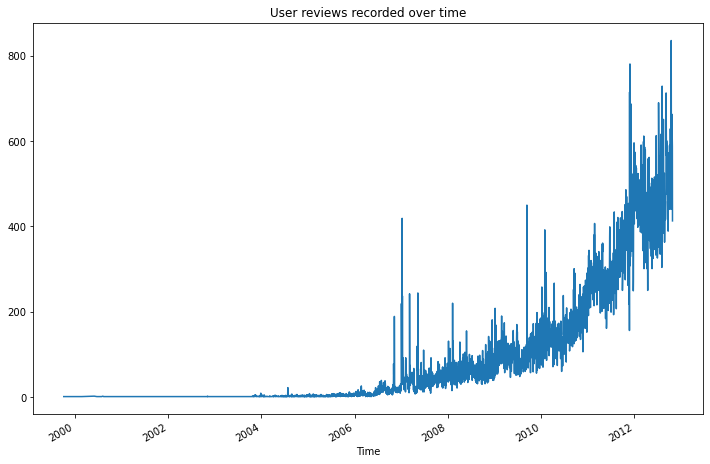

In [14]:
gb_time = profiles.groupby('Time').Id.count()

plt.figure(figsize=(12,8))
gb_time.plot(title='User reviews recorded over time')
plt.show()

To observe the trend in user reviews over the years (1999 to 2012), we shall plot a simple line graph as the time series plot. We observe an exponential increase in the number of reviews/ ratings recorded over time, which could be attributed to various factors.

In [15]:
# days receiving most reviews

gb_time.sort_values(ascending=False).head(10)

Time
2012-10-16    836
2011-11-28    781
2012-08-06    729
2011-11-25    715
2012-09-06    713
2012-07-09    690
2011-12-07    687
2012-10-22    663
2012-08-16    651
2012-10-18    651
Name: Id, dtype: int64

We observe that the most active dates/ dates with most number of reviews came from the latest years. 

### Distribution of Ratings

In [16]:
profiles.describe().drop('Id', axis=1)

# majority of users gave a rating of 4 or 5

,Score
count,395200.000000
mean,4.178758
std,1.312734
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


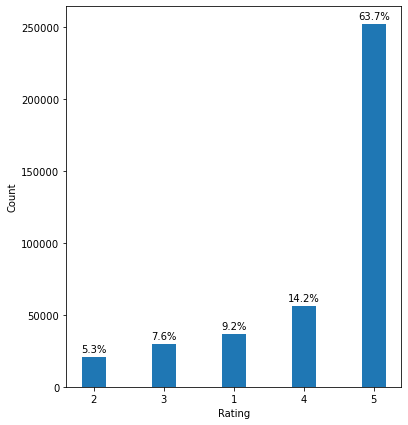

In [17]:
# plotting of bar graph for counts of all the ratings (1 to 5)

score_count = pd.DataFrame(profiles.groupby('Score').size())
score_count.sort_values(by=0, inplace=True)
score_percent = score_count/ncount*100
score_percent = score_percent[0].tolist()

labels = score_count.index.tolist()
plt.figure(figsize=(6, 7))
ax = plt.gca()
width = 0.35
x = np.arange(5)
rects = ax.bar(x, score_count[0], width) # counts (score_bar[0]) as height
for i,rect in enumerate(rects):
    h = rect.get_height() # counts
    ax.annotate('{}%'.format(round(score_percent[i],1)), # annotate bars with percentage of reviews given such rating
                    xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Indeed, ratings of 4 and 5 made up about 77.9% of ratings given overall. We see that generally, positive ratings were given by users.

### Distribution of Products that get Rated

In [18]:
pdtcounts = profiles['ProductId'].value_counts()
pdtcounts.describe()

count    71165.000000
mean         5.553292
std         15.467953
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        913.000000
Name: ProductId, dtype: float64

Products get 5-6 ratings on average, with the most rated product having 913 ratings. We may want to filter out products with less than 5 or 6 ratings to avoid the sparse ratings problem.

In [19]:
min_pdt_ratings = 5
filter_pdt = pdtcounts[pdtcounts > min_pdt_ratings]
filter_pdt = filter_pdt.index.tolist()

In [20]:
len(filter_pdt)/len(pdtcounts)*100

# 22% of products have >5 ratings

21.63282512471018

### Distribution of number of ratings given by Users (by UserId, not ProfileName)

In [21]:
usercounts = profiles['UserId'].value_counts()
usercounts.describe()

count    256059.000000
mean          1.543394
std           2.784385
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         329.000000
Name: UserId, dtype: float64

Each user rated about 1-2 on average, with the most active user giving 329 ratings in total. We may want to filter out users with less than 3 ratings to be able to predict their recommendations more accurately based off their preference.

In [22]:
min_user_ratings = 2
filter_user = usercounts[usercounts > min_user_ratings]
filter_user = filter_user.index.tolist()

In [23]:
len(filter_user)/len(usercounts)*100

# only ~8.5% of users have >2 rating

8.495698257042323

### Filtering out rarely rated Products (<=5 ratings in total) & rarely rating Users (<3 ratings)

In [24]:
profiles.shape

(395200, 10)

In [25]:
new_profiles = profiles.loc[(profiles['ProductId'].isin(filter_pdt)) & (profiles['UserId'].isin(filter_user))]
new_profiles.shape

(98183, 10)

## Check: time runs from 1999-2012, to filter to specific time period? which and how long

In [26]:
new_profiles.Time.describe()

<ipython-input-26-8e779e6ca860>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


count                   98183
unique                   2538
top       2012-03-22 00:00:00
freq                      241
first     2000-08-09 00:00:00
last      2012-10-26 00:00:00
Name: Time, dtype: object

To recommend products to users more accurately, we shall based off our predictions on their behaviour over the 2 latest years.

In [27]:
# filtering to 2 latest years

new_profiles = new_profiles[(new_profiles.Time >= datetime.strptime('2010-10-26', '%Y-%m-%d')) & 
                            (new_profiles.Time <= max(new_profiles.Time))]
new_profiles.shape

(64853, 10)

### User Demographics

In [28]:
# size of each Gender and Age Group

print(new_profiles.groupby('Gender')['Id'].count())
print(new_profiles.groupby('Age Group')['Id'].count())

Gender
female    32868
male      31985
Name: Id, dtype: int64
Age Group
20-29    10399
30-39    10834
40-49    10924
50-59    10909
<20      10977
>60      10810
Name: Id, dtype: int64


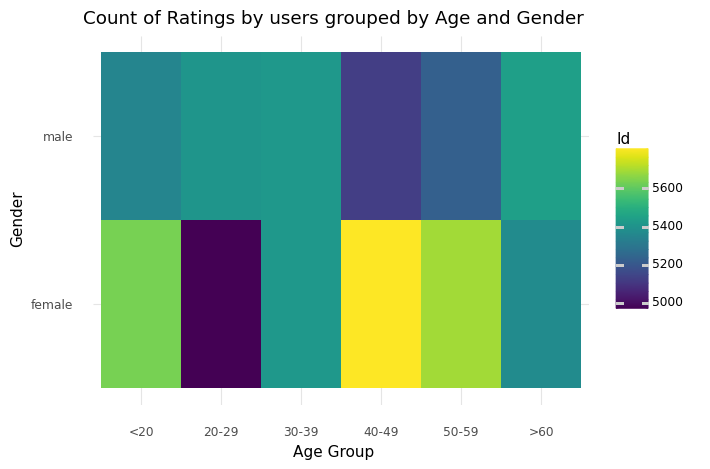

<ggplot: (197478239561)>

In [29]:
temp = new_profiles.groupby(['Age Group', 'Gender']).agg({
    'Id': 'count'
}).reset_index()

temp = temp.sort_values(by='Age Group')
(
ggplot(temp, aes(y='Gender', x='Age Group', fill='Id'))
    + geom_tile()
    + labs(x='Age Group', 
           y='Gender',title='Count of Ratings by users grouped by Age and Gender')
    + theme_minimal()
    + scale_x_discrete(name='Age Group', limits=['<20','20-29','30-39','40-49','50-59','>60'])
)

# most frequent users: Female 40-49
# least frequent users: Female 20-29
# certain groups tend to be bigger than others, but difference is not much, ~10% more

## --Misc--

In [30]:
# products most reviewed/rated

new_profiles.groupby('ProductId')['Id'].count().sort_values(ascending=False).head(10)

ProductId
B006MONQMC    476
B002IEZJMA    466
B002IEVJRY    456
B002LANN56    440
B001VJ0B0I    438
B0041NYV8E    437
B0051COPH6    360
B004ZIER34    303
B004BKLHOS    285
B004YV80OE    275
Name: Id, dtype: int64

In [31]:
new_profiles[new_profiles['ProductId'] == 'B005K4Q34S'].head(5)
# top reviewed/rated product keywords: drink, cup, coffee

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
531681,531682,B005K4Q34S,A12FGETYAHR723,"Gloria Gallagher ""cooknknit""",5,2012-10-22,Addicting its so good!!!,I love this coffee. So far have only had the ...,30-39,male
531704,531705,B005K4Q34S,A22KYJ5282CP1Z,"Bryan Booth ""Bryan Booth""",2,2012-10-05,Strong Artificial Sweetener taste,"I typically love vanilla cappuccino, and have ...",30-39,female
532069,532070,B005K4Q34S,A1IU4JZFDZA9HJ,"P. Boynton ""Middle School teacher""",5,2012-08-17,My new favorite for a cocoa-type drink,While Mocha Nut Fudge coffee is still my favor...,20-29,female
531982,531983,B005K4Q34S,A278X0N21YYWKE,Kathryn Dasher Childers,5,2012-07-20,Awesome Flavor!,Perfect drink for beginning morning or before ...,20-29,male
532125,532126,B005K4Q34S,AXA2AK79YLGEN,ladypen,1,2012-07-05,horrid ingredients.,"Conveniently, ingredients not listed but for ...",30-39,female


In [32]:
# Is UserId attached to ProfileName?

profiles[profiles['ProfileName'] == 'Linda Painchaud-Steinman "PARK EDGE BOOKS"'].head(5) 
# yes

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
538373,538374,B0061IUIDY,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",4,2012-08-02,Hearty Flavor,"I drink coffee at breakfast, but regularly enj...",20-29,female
562971,562972,B007JFMH8M,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",5,2012-07-28,Great Anytime of Day!,Quaker Soft Baked Oatmeal Cookies with raisins...,20-29,female
288738,288739,B005A1KZC2,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",3,2012-05-29,"Very Good, for anyone with Expensive Taste",Please pardon my lousy attempt at a pun in the...,20-29,female
71828,71829,B007RTR8AC,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",4,2012-05-29,"Volumizes, but might fade color?","First, a note about packaging for this shampoo...",20-29,female
135412,135413,B005VOOM4A,A1JAPP1CXRG57A,"Linda Painchaud-Steinman ""PARK EDGE BOOKS""",5,2012-05-06,"Rich, Robust Flavor, and other good stuff, too.",The following are quotes from the box of Marle...,20-29,female


In [33]:
profiles[profiles['ProfileName'] == 'Karl'].head(5) 

# some UserId not associated with ProfileName 
# *check: shouldn't have duplicates here

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
244813,244814,B001FA1E4U,A2K70G893JBLH8,Karl,5,2012-04-28,ADDICTIVE,These are MY ABSOLUTE FAVORITE THINGS.<br />Be...,30-39,male
315273,315274,B004S07G1O,A11IJ39FJ33AGR,Karl,2,2012-03-09,Where's the chicken ?,I bought this stew a few days ago because I re...,20-29,male
258737,258738,B0049FLNCQ,A2KDG54BLNOE2,Karl,4,2012-03-06,Great Taste & Perfect for a meal replacement,"Been using this product for the last 6 weeks, ...",40-49,male
256432,256433,B001EO5PNI,A2CU76B9ZDVLL3,Karl,1,2011-12-30,"The worst excuse for ""glazed"" almonds!","I bought these because they are named ""Cinnamo...",50-59,male
34393,34394,B004XX1NKQ,A3ERW4BD2SMOTF,Karl,5,2011-12-12,Such a difference,i've spent many years eating asian food and us...,<20,female


In [34]:
new_profiles[new_profiles['ProfileName'] == 'Karl'].head(5) 

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Age Group,Gender
42806,42807,B002NHYQAS,AO2EURP2Y4JZM,Karl,4,2011-02-23,"Medium-dark, not bitter, somewhat creamy",I happily accepted a review bar as I am a fan ...,40-49,male
133281,133282,B0090X8IPM,AO2EURP2Y4JZM,Karl,3,2010-11-23,Most people will like this; aficionados not so...,This Starbucks coffee is a (very consistent) m...,40-49,male


## --End of Misc--

<a id='surp'></a>
## Recommender System: Surprise package

Next, we shall use the Surprise package to perform our predictions and attain product recommendations for users based on their own ratings and others' that have been given before, using Collaborative Filtering. 

<a href=#top>(back to top)</a>

In [38]:
# conda install -c conda-forge scikit-surprise

In [50]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import accuracy
np.random.seed(3101)

In [39]:
data_for_surprise = new_profiles[['UserId', 'ProductId', 'Score']].reset_index(drop=True)
data_for_surprise.head()

,UserId,ProductId,Score
0,A33W5JAFGHYRQZ,B001EO5RSQ,5
1,A353IAF5Y1XE53,B000HB9TLI,1
2,A18NG9I9MT2V8I,B000SDKDM4,5
3,A1TED4G0PWZPQV,B000FIWIWA,5
4,A235UFZGCFN3J5,B005Y10XZ2,5


In [40]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data_for_surprise, reader)
trainset = data.build_full_trainset()

print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  17011 

Number of items:  12429


## Trying algo: KNNWithMeans 
- KNNWithMeans: mean rating of each user is taken into account

In [41]:
# message Memory Error if number of users is too large

np.random.seed(3101)
my_k = 30 # kNN: Number of K
my_min_k = 5 # if cannot find k=30, then at least 5 neighbours
my_sim_options = {'name': 'cosine','user_based': True}  # compute similarities between users

algo = KNNWithMeans(k = my_k, min_k = my_min_k, sim_options = my_sim_options, verbose =True)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
# Using RMSE: standard deviation of the residuals/ prediction errors
# can also use MAE (average absolute deviation between predicted rating and users true rating) as accuracy metric)

np.random.seed(3101)
results = cross_validate(algo = algo, data = data, measures=['RMSE'], cv=5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [43]:
# results

for key in results:
    if type(results[key] == tuple):
        print('Mean for ' + key + ': ' + str(sum(results[key])/5))
    else:
        print('Mean for ' + key + ': ' + str(results[key].mean()))

Mean for test_rmse: 1.2419038538615363
Mean for fit_time: 17.377540636062623
Mean for test_time: 2.1070046424865723


In [44]:
trainset, testset = train_test_split(data, test_size=0.2)
algo = KNNWithMeans(k = my_k, min_k = my_min_k, sim_options = my_sim_options, verbose =True)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2516


1.2515628205194829

The following functions are edited and originate from:

https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb

In [45]:
def get_IbyU(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_UbyI(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError: # item not part of the trainset
        return 0
    
knnb_df = pd.DataFrame(predictions, columns=['UserId', 'ProductId', 'Score', 'Est', 'Details'])

""" knnb_df
args:
    uid: UserId
    iid: ProductId
    score: actual Score/rating given by User for that Product
    est: predicted Score
    details: consists of actual k neighbours used for prediction and if it was impossible to predict the rating
"""

knnb_df['No. items rated by user'] = knnb_df.UserId.apply(get_IbyU)
knnb_df['No. users rating item'] = knnb_df.ProductId.apply(get_UbyI)
knnb_df['Err'] = abs(knnb_df.Est - knnb_df.Score) 
best_predictions = knnb_df.sort_values(by='Err')[:10]
worst_predictions = knnb_df.sort_values(by='Err')[-10:]

In [46]:
best_predictions

# no. items and no. users are 1 for some because test set, not the entire data_for_surprise

,UserId,ProductId,Score,Est,Details,No. items rated by user,No. users rating item,Err
0,A13CZ8CTDBAY68,B001KUQHVA,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,1,0.0
5662,A3W67RJT8P73U,B001P7370C,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,0.0
5668,A1NC0H3L3ZMG5U,B0045WW53O,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,1,0.0
5673,A1ASIHK78FY9JQ,B0002DGL26,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",2,5,0.0
5675,A1OGSBT1IG0A64,B001E5E1MI,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,13,0.0
5681,A363G1YJ30V3SJ,B003VZCZ0O,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,5,0.0
5682,A3JXKY4SS4V7Z1,B0018Q1O3W,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,2,0.0
5686,ADEFGEYL605GW,B001PMCFL4,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,2,0.0
5692,AVSQ0D9545XYN,B0009F3S78,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",3,6,0.0
5693,A3FG4TRR8815R3,B0030V9HV4,5.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,1,0.0


In [47]:
worst_predictions

,UserId,ProductId,Score,Est,Details,No. items rated by user,No. users rating item,Err
1380,A2A7AFPDGLYLHK,B001EYUE5M,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,4,4.0
10679,A3U8BNI2PTRUCQ,B004YV7YL4,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,4,4.0
10313,A26F90M6FKBVGY,B001ELL60W,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,21,4.0
10685,A36N62I47U9IIH,B003G2LIIW,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,1,4.0
1253,A3NP1G6SFO0GBR,B0012KCUUU,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,4,4.0
2817,A3D6R22GIUKINS,B002RNYDBU,5.0,1.0,"{'actual_k': 0, 'was_impossible': False}",1,2,4.0
8712,ADT7O1C83DE53,B0026VPVK0,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",2,2,4.0
8950,A1HTC4BKKYA9VC,B004741298,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,1,4.0
9798,A24GQGZAYUJCFD,B007JFMIWW,1.0,5.0,"{'actual_k': 4, 'was_impossible': False}",1,55,4.0
4142,APZ867OSBNF9Q,B000MT8G64,1.0,5.0,"{'actual_k': 0, 'was_impossible': False}",1,1,4.0


Analysis of worst predictions? eg. bad because lack of data or anomaly users in terms of ratings? k=0 for a lot of the worst predictions.

### Analysis of other Algorithms in Surprise

In [51]:
benchmark = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    temp = pd.DataFrame.from_dict(results).mean(axis=0)
    temp = temp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(temp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1253  1.1439  1.1357  1.1349  0.0076  
Fit time          2.03    2.01    1.95    1.99    0.03    
Test time         0.17    0.20    0.13    0.17    0.03    
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1324  1.1367  1.1312  1.1334  0.0024  
Fit time          5.63    5.36    5.47    5.49    0.11    
Test time         0.37    0.28    0.28    0.31    0.04    
Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2688  1.2707  1.2598  1.2664  0.0048  
Fit time          1.52    2.07    1.75    1.78    0.22    
Test time         0.18    0.16    0.16    0.17    0.01    
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3831  1.38

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.133437,5.488484,0.312067
SVD,1.134940,1.994913,0.166870
BaselineOnly,1.137245,0.095524,0.087726
KNNBaseline,1.157673,4.288681,1.348490
KNNBasic,1.200205,3.724211,1.006338
KNNWithMeans,1.258504,3.977771,0.902335
KNNWithZScore,1.262159,4.155051,1.045280
CoClustering,1.263886,2.770974,0.099263
SlopeOne,1.266414,1.781112,0.168260
